# Important notes

- Since the objective is to implement and run the best model identified during the tuning stage, we have copied all necessary imports, functions, and classes into the final section (1.4). This section is designed to allow the tester to execute the notebook cells sequentially from 1.4 and seamlessly produce the desired output for the final mypredict() function with the best model chosen.

- While this structure prioritizes ease of use and practicality for evaluation purposes, it does not reflect the original modular and optimized workflow we followed during development. Above section 1.4, the code is organized to maximize readability, reproducibility, and clarity. The duplication of functions and imports in the final section is solely to ensure standalone execution for practicality.

- We have run the notebook based on our file structure initially with a path of "Datasets/Data 1.csv.gz" to get the dataser. However in the final task 1.4 the paths are adapted to the assignment asumptions so that they run perfectly within the tester's system for the best model.

# Main Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import datetime
import time
import json # Export dictionary of tuned parameters.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV # For hyperparameter tuning.
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import BaggingClassifier, StackingClassifier

from sklearn.base import BaseEstimator, ClassifierMixin


# Evaluation metrics import
from sklearn.metrics import (
    accuracy_score, 
    balanced_accuracy_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix,
    precision_recall_curve,
    precision_score,
    recall_score
)

from sklearn.metrics import classification_report

# Models import
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Visualisations import
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import metrics
from sklearn import manifold
from sklearn import discriminant_analysis

import joblib

# Task 1.1 Exploration

In [117]:
# Load Data
def load_data(file_path):
    return pd.read_csv(file_path, compression='gzip')

In [119]:
file_path = "Datasets/Data 1.csv.gz" 
label_column = "label" 

# Load the dataset
df = load_data(file_path)

In [120]:
print(df.shape)
df[0:5]

(5471, 4124)


,label,DPM1,NIPAL3,KRIT1,LAP3,CD99,MAD1L1,LASP1,M6PR,CFLAR,...,CISD3,DDX52,GGNBP2,C11orf98,MRPL45,TRG.AS1,EBLN3P,TRBV7.2,AC010642.2,POLR2J3.1
0,TREG,0.000000,0.0,0.0,0.0,4.459588,0.000000,4.175754,3.107406,3.107406,...,0.000000,0.000000,0.000000,3.777941,0.000000,0.000000,0.000000,0.000000,3.107406,0.000000
1,TREG,0.000000,0.0,0.0,0.0,3.159469,3.159469,0.000000,0.000000,3.159469,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.484917,0.000000,0.000000
2,CD4+T,3.568377,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.568377,0.000000,0.000000,0.000000,0.000000
3,CD4+T,2.574454,0.0,0.0,0.0,3.228759,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.574454,0.000000,0.000000,2.574454,0.000000,2.574454,0.000000,0.000000,2.574454
4,CD4+T,0.000000,0.0,0.0,0.0,0.000000,3.418392,0.000000,0.000000,0.000000,...,2.757484,0.000000,3.418392,0.000000,0.000000,2.757484,3.418392,0.000000,0.000000,0.000000


In [121]:
sparsity_X = (df == 0).mean().iloc[1:]

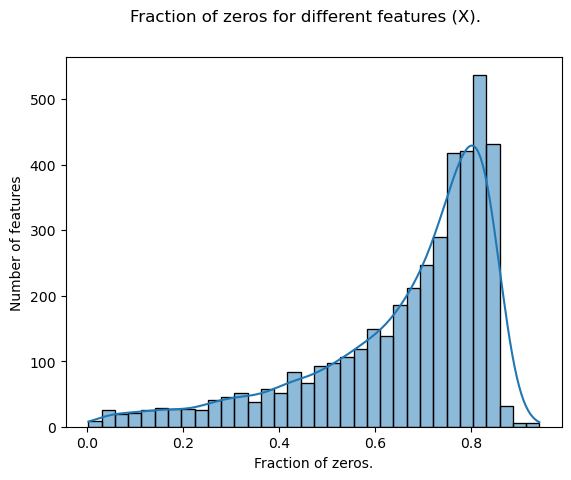

In [122]:
fig, ax = plt.subplots()
ax = sns.histplot(data=sparsity_X, kde=True)
fig.suptitle("Fraction of zeros for different features (X).")
ax.set_ylabel("Number of features")
ax.set_xlabel("Fraction of zeros.")
fig.savefig("Figures/t11_sparsity.pdf")
plt.show()

In [123]:
sum(df.isna().sum())

0

In [124]:
df["label"].value_counts()

label
CD4+T    3356
TREG     2115
Name: count, dtype: int64

### PCA for visual analysis

In [125]:
# Prepare the input features (X) by selecting predictor variables and excluding the target (label).
regressors = df.columns.to_list()
regressors.remove("label")
regressors[0:5] 


X = df[regressors]

# Standardize the features to ensure equal contribution of all variables by scaling them to zero mean and unit variance.
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_standardized = scaler.transform(X)

# Apply Principal Component Analysis (PCA) to reduce the dimensionality of the dataset to two components, 
pca = decomposition.PCA(n_components=2)
pca_x_component = pca.fit_transform(X_standardized)

# retaining the most significant variance in the data.
df_pca_x = pd.DataFrame(pca_x_component)

# Combine the PCA-transformed features with the original target variable for further analysis or visualization.
df_pca_x = pd.concat([df['label'],df_pca_x],axis=1)

We visualize the relationship between the two PCA components (0 and 1)

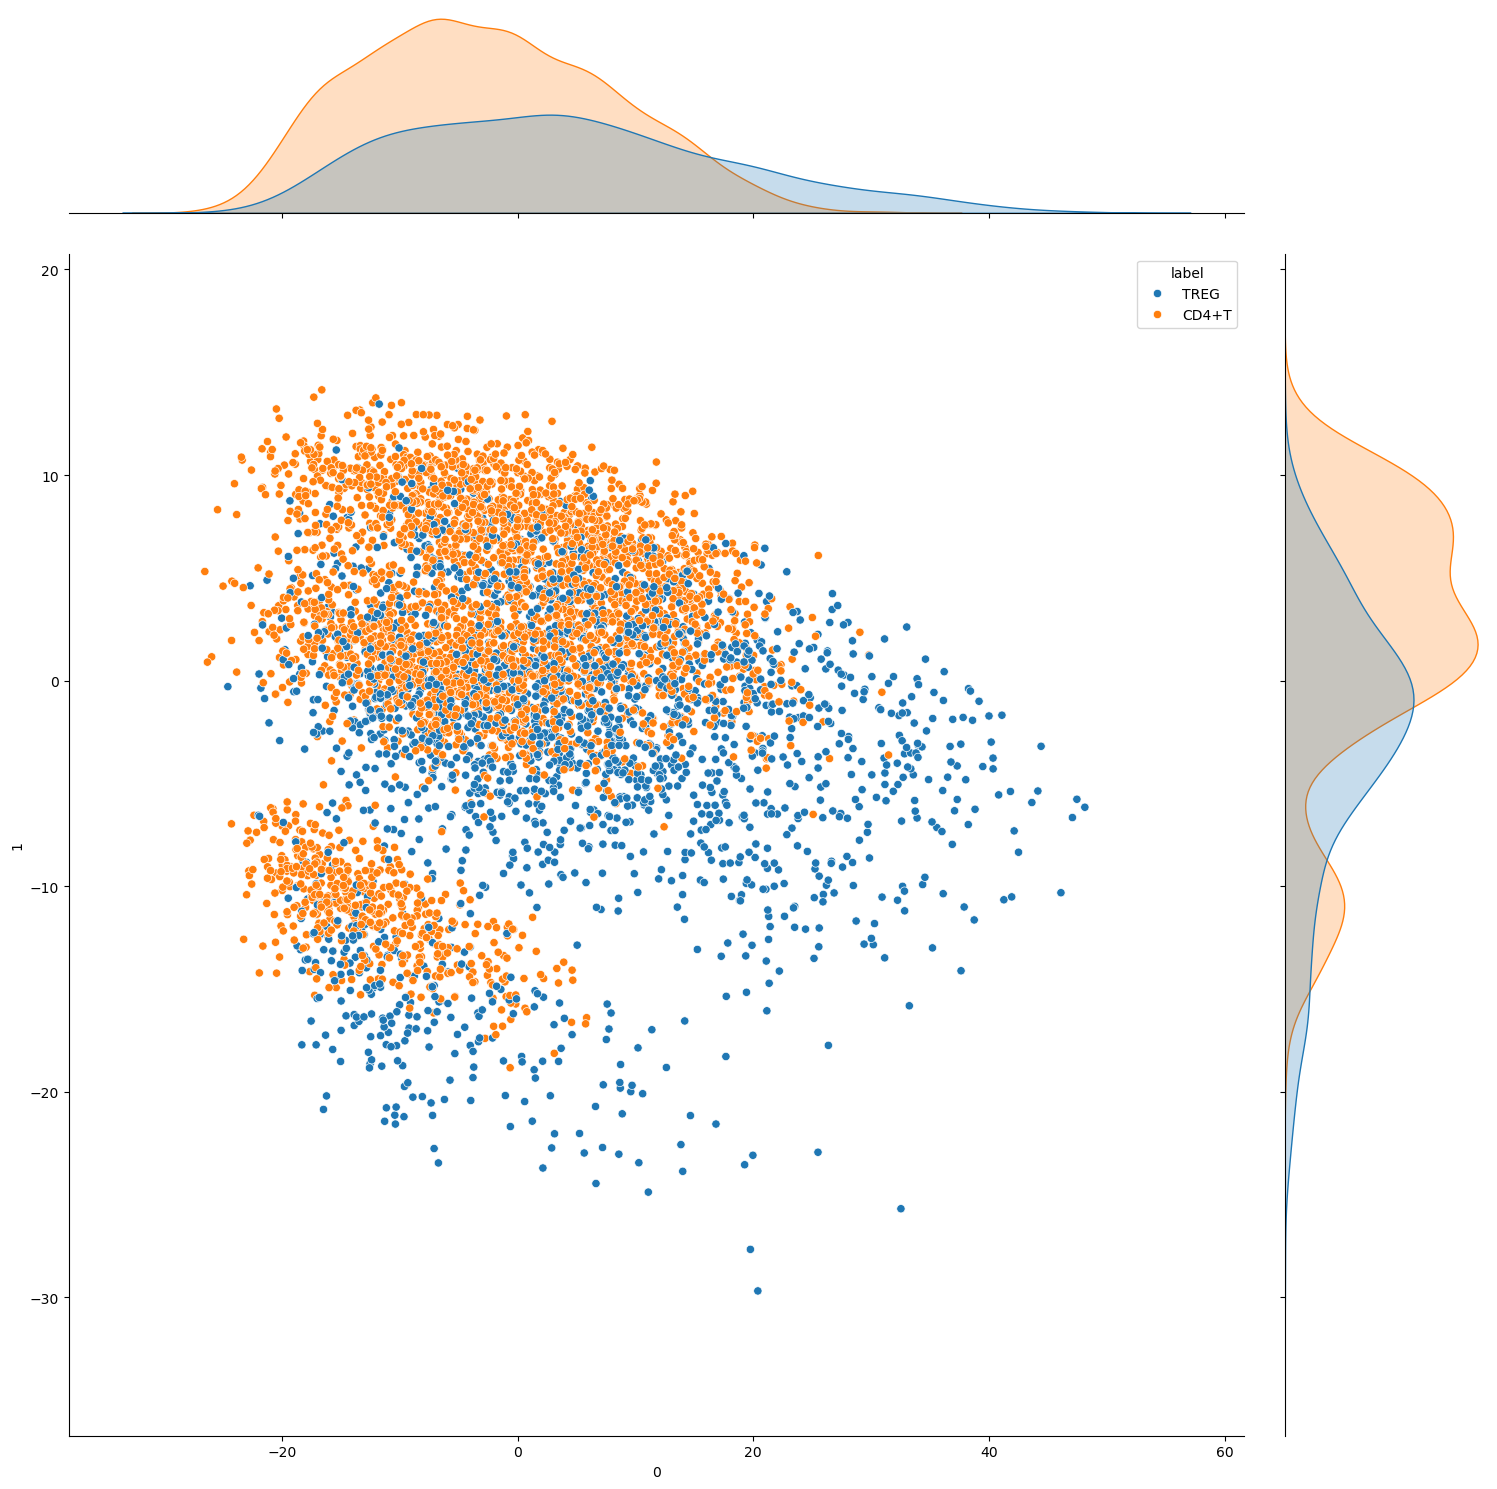

In [126]:
sns.jointplot(data=df_pca_x, x=0, y=1, hue="label",height=15)

Then we perform PCA to extract explained variance ratio and compute cumulative variance for assessing dimensionality.

In [127]:
pca = decomposition.PCA()
pca_x_component = pca.fit(X_standardized)
pca_x_component.explained_variance_ratio_
scree_data = pca_x_component.explained_variance_ratio_
scree_data = scree_data.cumsum()

We also visualize cumulative variance retained by PCA components with a scree plot, highlighting the variance retained by the first 10 components

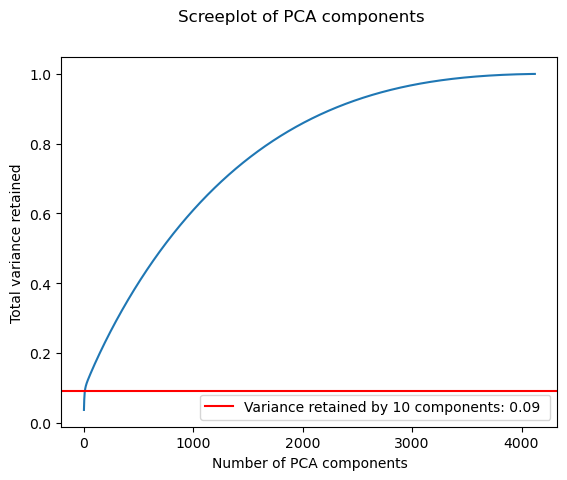

In [128]:
fig, ax = plt.subplots()      
ax.plot(scree_data)
ax.axhline(scree_data[9], 
           color = 'r', 
           label = f'Variance retained by 10 components: {round(scree_data[9],2)} '
          )
ax.set_ylabel("Total variance retained")
ax.set_xlabel("Number of PCA components")
ax.legend(loc="lower right")
fig.suptitle("Screeplot of PCA components")
fig.savefig("Figures/t11_screeplot.pdf")
plt.show()

We performed dimensionality reduction using t-SNE and prepare a DataFrame with the 2D embedded features alongside the labels

In [129]:
X_embedded = manifold.TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=30,random_state=42).fit_transform(X_standardized)
X_tsne = pd.DataFrame(X_embedded)
df_tsne_2 = pd.concat([df['label'],X_tsne],axis=1)

We also visualize joint density of the t-SNE 2D embedding by label to highlight group distinctions

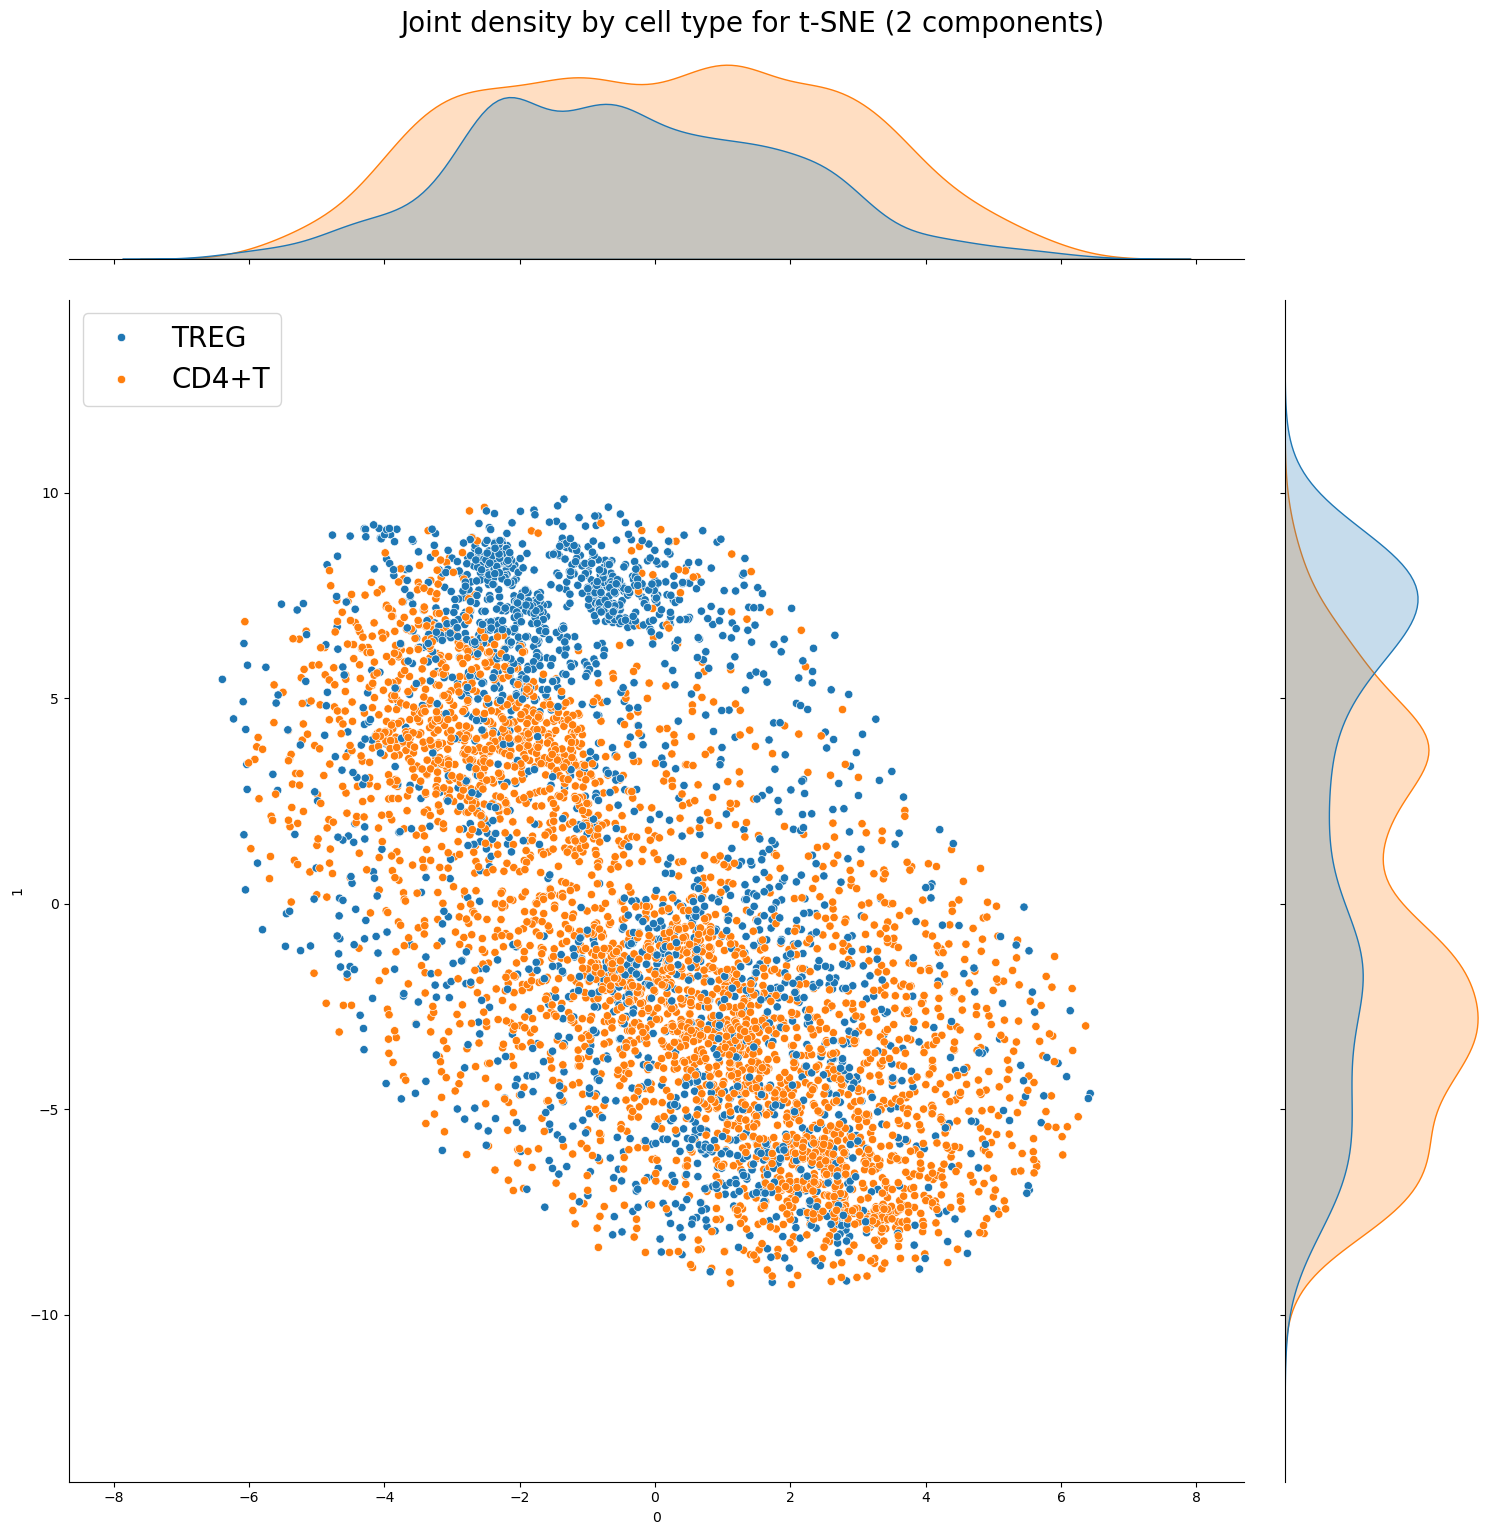

In [130]:
fig = sns.jointplot(data=df_tsne_2, x=0, y=1, hue="label",height=15).figure
fig.suptitle("Joint density by cell type for t-SNE (2 components)",fontsize=20 ,y = 1.02)
plt.legend( fontsize="20", loc ="upper left")
plt.savefig("Figures/t11_joint_tsne.pdf")
plt.show()

# Task 1.2 Hyperparameter tuning workflow related functions

In [ ]:
def plot_confusion_matrix(confusion, labels, title="Confusion Matrix"):
    """
    Plots a heatmap for the given confusion matrix with annotations
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()


In [4]:
def load_data(file_path):
    """
    Load a dataset from a specified file path. Supports gzip-compressed files.
    """
    return pd.read_csv(file_path, compression='gzip')


In [ ]:
def train_split(data, label_col, random_state=42, test_size=0.2):
    """
    Splits the dataset into training and testing sets without preprocessing
    """
    X = data.drop(columns=[label_col]).values
    y = LabelEncoder().fit_transform(data[label_col].values)
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

This implementation of the ModelPipeline class was chosen to ensure a structured, modular, and reusable workflow for training, tuning, and evaluating the models. By encapsulating standard preprocessing steps (like scaling and PCA), hyperparameter tuning, and evaluation in a single class, the pipeline minimizes code repetition. The dynamic configuration of pipelines allows us to focus on the customization process for the different models in the task.

In [ ]:
class ModelPipeline:
    def __init__(self, model, name, standardize=False, with_pca=False, n_pca_components=10, random_state=42):
        """
        Constructor to initialize the pipeline for any given model
        - model: The ML model (e.g. LDA, RandomForest)
        - name: A unique name for the model (used for the analysis)
        - standardize: Whether to apply StandardScaler
        - with_pca: Whether to include PCA in the workflow
        - n_pca_components: Number of PCA components (only if PCA is used)
        """
        self.model = model
        self.name = name
        self.standardize = standardize
        self.with_pca = with_pca
        self.n_pca_components = n_pca_components
        self.random_state = random_state

        self.pipeline = None
        self.best_params = {}
        self.results = {}  # Store evaluation results for each model

        # Ensure model uses random_state if supported (fixing randomness for reproducibility)
        if "random_state" in self.model.get_params():
            self.model.set_params(random_state=self.random_state)

    def create_pipeline(self):
        """
        Assembles the pipeline steps dynamically based on the configuration:
        1- Adds StandardScaler if standardize=True
        2- Adds PCA if with_pca=True
        3- Adds the given model
        """
        steps = []
        if self.standardize:
            steps.append(('scaler', StandardScaler()))
        if self.with_pca:
            steps.append(('pca', PCA(n_components=self.n_pca_components)))
        steps.append((self.name, self.model))
        self.pipeline = Pipeline(steps)
        # print(f"Pipeline Created: {self.pipeline}") debugged!
        return self.pipeline

    def set_params(self, params):
        """
        Updates the parameters of the pipeline.
        - params: Dictionary of parameters to set for the tuning
        """
        if not self.pipeline:
            raise ValueError("Pipeline not created. Call create_pipeline() first.")
        self.pipeline.set_params(**params)

    def tune(self, X_train, y_train, param_grid, scoring="f1", cv_folds=5, n_jobs=-1):
        """
        Performs hyperparameter tuning using GridSearchCV
        - X_train, y_train: Training data and labels
        - param_grid: Grid of hyperparameters to tune
        - scoring: base the scoring on the f1 metric (task based)
        - cv_folds: Number of cross-validation folds (5 for us)
        - n_jobs: Number of parallel jobs for GridSearchCV (-1 means maximum possible for the system)
        """
        # Esnsure pipeline is created
        if not self.pipeline:
            self.create_pipeline() 

        # Setup GridSearchCV with the pipeline
        grid_search = GridSearchCV(
            self.pipeline,
            param_grid=param_grid,
            scoring=scoring,
            cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state),
            n_jobs=n_jobs,
            verbose=0
        )


        start_time = time.time() # Track tuning time
        grid_search.fit(X_train, y_train) # Fit the grid search
        elapsed_time = (time.time() - start_time) / 60 # Time in minutes (Some model tuning takes over an hour)

        # Store the best parameters and save results
        self.best_params = grid_search.best_params_
        self.best_params["MODEL_NAME"] = self.name
        self.best_params["TIME_ELAPSED_MIN"] = elapsed_time

        # Handle non-serializable objects
        serializable_params = {
            k: (str(v) if not isinstance(v, (int, float, str, list, dict)) else v)
            for k, v in self.best_params.items()
        }

        # Save all results and best parameters
        full_results = pd.DataFrame(grid_search.cv_results_)
        full_results.to_csv(f"Tuning_params/{self.name}_all_results.csv", index=False)
        with open(f"Tuning_params/{self.name}_best_params.json", "w") as f:
            json.dump(serializable_params, f, indent=4)
        print(f"Model {self.name} tuned in {elapsed_time:.2f} minutes") #log running time

    def evaluate(self, X_train, X_test, y_train, y_test):
        """
        Evaluates the performance of the pipeline on test data
        - X_train, X_test: Training and testing feature matrices
        - y_train, y_test: Training and testing labels
        """
        if not self.pipeline:
            self.create_pipeline()

        if self.best_params:
            # Filter only valid pipeline parameters (Important for Adaboost)
            valid_params = {
                key: value for key, value in self.best_params.items()
                if key in self.pipeline.get_params()
            }
            print(f"Valid Parameters for Pipeline: {valid_params}")
            self.pipeline.set_params(**valid_params) # Set valid params

        # Train the pipeline on training data
        self.pipeline.fit(X_train, y_train)
        # Predict on test data
        y_pred = self.pipeline.predict(X_test)

        # Compute evaluation metrics
        metrics = {
            "Model": self.name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
        }

        # Calculate AUC if available (not available forr SVM)
        if hasattr(self.pipeline, "predict_proba"):
            metrics["AUC"] = roc_auc_score(y_test, self.pipeline.predict_proba(X_test)[:, 1])
        else:
            metrics["AUC"] = None

        # Add confusion matrix (fir plot)
        metrics["Confusion Matrix"] = confusion_matrix(y_test, y_pred).tolist()
        print(f"Evaluation Results: {metrics}")

        # # Save evaluation metrics
        self.results = metrics
        pd.DataFrame([metrics]).to_csv(f"Tuning_params/{self.name}_evaluation_summary.csv", index=False)



In [ ]:
def aggregate_results(models):
    """
    Aggregates results from multiple ModelPipeline instances into a single DataFrame (To merge all models' results for readability)
    """
    all_results = [model.results for model in models]
    results_df = pd.DataFrame(all_results)
    results_df.to_csv("Model_Comparison_Results.csv", index=False)
    print("Aggregated results saved to Model_Comparison_Results.csv")
    return results_df


### Loading data

In [8]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Train-Test Split
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)


### LDA Without PCA

In [ ]:
lda_model = ModelPipeline(
    model=LinearDiscriminantAnalysis(),
    name="lda",
    standardize=True,
    with_pca=False
)
lda_model.create_pipeline()
lda_grid = [
    {"lda__solver": ["svd"]}, # Efficient for large datasets
    {"lda__solver": ["lsqr"], "lda__shrinkage": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, "auto"]} # least squares supports shrinkage params
]

In [ ]:
lda_model.tune(X_train, y_train, lda_grid)

In [146]:
lda_model

In [11]:
lda_model.evaluate(X_train, X_test, y_train, y_test)

Valid Parameters for Pipeline: {'lda__shrinkage': 0.8, 'lda__solver': 'lsqr'}
Evaluation Results: {'Model': 'lda', 'Accuracy': 0.965296803652968, 'Balanced Accuracy': 0.95587000064612, 'F1 Score': 0.9511568123393316, 'AUC': 0.9932336872635381, 'Confusion Matrix': [[687, 6], [32, 370]]}


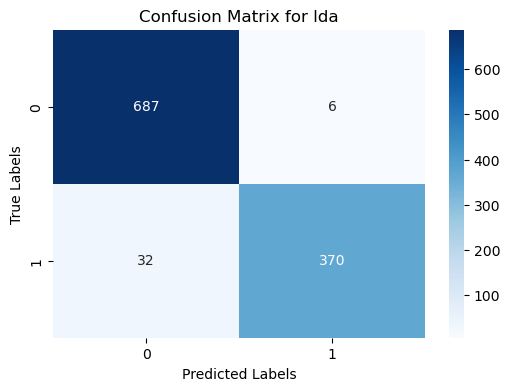

In [12]:
confusion = lda_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test))
plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {lda_model.name}")

### LDA with PCA (10 components)

In [67]:
lda_pca_model = ModelPipeline(
    model=LinearDiscriminantAnalysis(),
    name="lda_pca",
    standardize=True,
    with_pca=True,  # Enable PCA
    n_pca_components=10  # Fixed 10 components for benchmarking
)

lda_pca_model.create_pipeline()

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('lda_pca', LinearDiscriminantAnalysis())])

In [68]:
lda_pca_model.evaluate(X_train, X_test, y_train, y_test)

Evaluation Results: {'Model': 'lda_pca', 'Accuracy': 0.94337899543379, 'Balanced Accuracy': 0.9244524132583833, 'F1 Score': 0.9171122994652406, 'AUC': 0.9898379674499077, 'Confusion Matrix': [[690, 3], [59, 343]]}


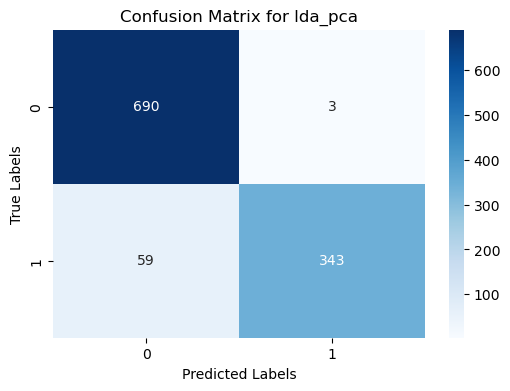

In [69]:
confusion = lda_pca_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test))

plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {lda_pca_model.name}")

### Tuning Logistic classifier without PCA

In [ ]:
# Fixed parameters for logistic regression
logit_fixed_params = {
    "logit__max_iter": 100, # Sufficient iterations for convergence
    "logit__solver": "saga", # supports elasticnet regularisation and efficient for large datasets
    "logit__n_jobs": -1,
    "logit__penalty": "elasticnet" # Combine L1 and L2 regularization for sparcity and smoothness
}

logit_grid_params = {
    "logit__C": [0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801, 0.901, 1.001, 5, 10], # Small val increase reg / large val reduce it
    "logit__l1_ratio": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # range from pure L2 to pure L1
    "logit__class_weight": [None, "balanced"] # balance adjusts weights inversly proportional to class frequencies
}

logit_model = ModelPipeline(
    model=LogisticRegression(),
    name="logit",
    standardize=True,
    with_pca=False
)

logit_model.create_pipeline()
logit_model.set_params(logit_fixed_params)

In [ ]:
logit_model.tune(X_train, y_train, logit_grid_params)

In [23]:
logit_model.evaluate(X_train, X_test, y_train, y_test)

Valid Parameters for Pipeline: {'logit__C': 0.401, 'logit__class_weight': None, 'logit__l1_ratio': 0.7}
Evaluation Results: {'Model': 'logit', 'Accuracy': 0.9579908675799087, 'Balanced Accuracy': 0.9537539574853008, 'F1 Score': 0.9425, 'AUC': 0.9934849561715233, 'Confusion Matrix': [[672, 21], [25, 377]]}


/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


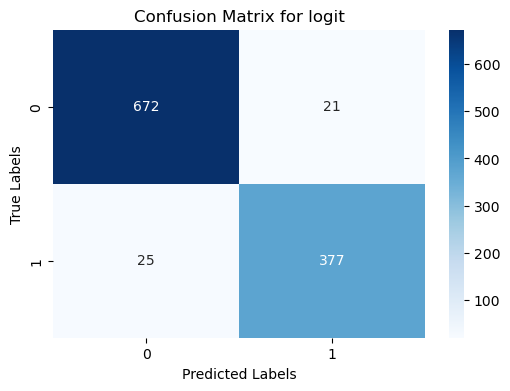

In [24]:
confusion = logit_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test))
plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {logit_model.name}")

### Tuning logistic classifier with PCA (10 component)

In [70]:
logit_pca_model = ModelPipeline(
    model=LogisticRegression(),
    name="logit_pca",
    standardize=True,
    with_pca=True,
    n_pca_components=10  # Fixed 10 components for benchmarking
)

logit_pca_model.create_pipeline()

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('logit_pca', LogisticRegression(random_state=42))])

In [71]:
logit_pca_model.evaluate(X_train, X_test, y_train, y_test)

Evaluation Results: {'Model': 'logit_pca', 'Accuracy': 0.960730593607306, 'Balanced Accuracy': 0.9548738989037497, 'F1 Score': 0.9457755359394704, 'AUC': 0.9915932602499766, 'Confusion Matrix': [[677, 16], [27, 375]]}


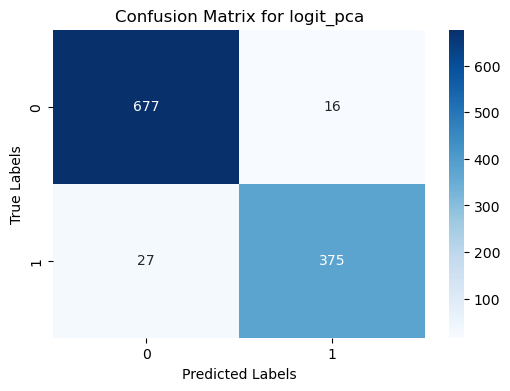

In [72]:
# Extract results
confusion = logit_pca_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test))

plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {logit_pca_model.name}")

### Tuning QDA without PCA 

In [ ]:
qda_model = ModelPipeline(
    model=QuadraticDiscriminantAnalysis(),
    name="qda",
    standardize=True, # QDA is sensitive to feature scales
    with_pca=False
)
qda_model.create_pipeline()

qda_grid = [
    {
        "qda__reg_param": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # 0: no regularization (overfitting risk) -> >0: reduce sensitivity to moise 
    }
]


In [ ]:
qda_model.tune(X_train, y_train, qda_grid)

In [30]:
qda_model.evaluate(X_train, X_test, y_train, y_test)

Valid Parameters for Pipeline: {'qda__reg_param': 0.1}


/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Evaluation Results: {'Model': 'qda', 'Accuracy': 0.36712328767123287, 'Balanced Accuracy': 0.5, 'F1 Score': 0.5370741482965932, 'AUC': 0.5, 'Confusion Matrix': [[0, 693], [0, 402]]}


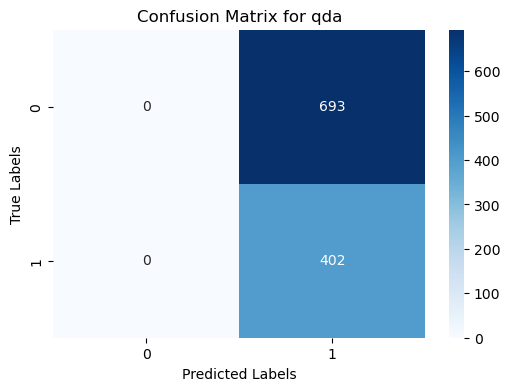

In [31]:
confusion = qda_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test))
plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {qda_model.name}")

### Tuning QDA with PCA

In [73]:
qda_pca_model = ModelPipeline(
    model=QuadraticDiscriminantAnalysis(),
    name="qda_pca",
    standardize=True,
    with_pca=True,
    n_pca_components=10  # Fixed 10 components for PCA
)

qda_pca_model.create_pipeline()

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('qda_pca', QuadraticDiscriminantAnalysis())])

In [74]:
qda_pca_model.evaluate(X_train, X_test, y_train, y_test)

Evaluation Results: {'Model': 'qda_pca', 'Accuracy': 0.9534246575342465, 'Balanced Accuracy': 0.9454459305205574, 'F1 Score': 0.9351969504447268, 'AUC': 0.9896872061051165, 'Confusion Matrix': [[676, 17], [34, 368]]}


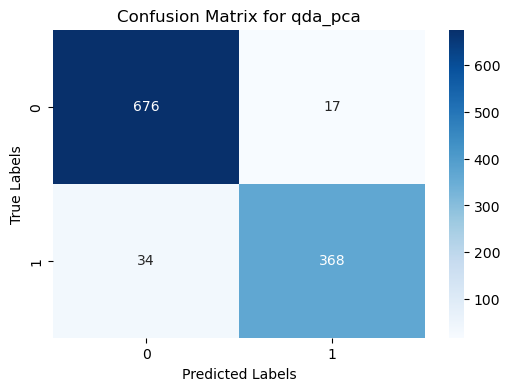

In [75]:
# Extract evaluation results
confusion = qda_pca_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test))

# Plot confusion matrix
plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {qda_pca_model.name}")

### Tuning K-nn without PCA

In [ ]:
# Initialize KNN Model without PCA
knn_model = ModelPipeline(
    model=KNeighborsClassifier(),
    name="knn",
    standardize=True, # crucial because knn is distance based
    with_pca=False
)

knn_model.create_pipeline()

# Apply fixed parameters
knn_fixed_params = {
    "knn__metric": 'minkowski', # generalizes the Euclidean and Manhattan distances (offers more flexibility for different data distributions)
    "knn__n_jobs": 1
}

knn_grid = [
    {
        "knn__p": [0.8, 1.0, 1.2, 1.4, 1.7, 2.0, 2.2, 3.0, 10.0], # power of the Minkowski metric (fractional (0.8) to Euclidean (2.0))
        "knn__weights": ['uniform', 'distance'], # uniform: All neighbors contribute equally // distance: Closer neighbors have more influence (local variability is accounted for)
        "knn__n_neighbors": [1, 3, 5, 9, 11, 15, 20, 30] # Number of neighbours
    }
]


knn_model.set_params(knn_fixed_params)


In [ ]:
knn_model.tune(X_train, y_train, knn_grid)

In [37]:
knn_model.evaluate(X_train, X_test, y_train, y_test)

Valid Parameters for Pipeline: {'knn__n_neighbors': 30, 'knn__p': 10.0, 'knn__weights': 'distance'}
Evaluation Results: {'Model': 'knn', 'Accuracy': 0.7881278538812785, 'Balanced Accuracy': 0.7772501130710086, 'F1 Score': 0.7184466019417476, 'AUC': 0.8737553215165156, 'Confusion Matrix': [[567, 126], [106, 296]]}


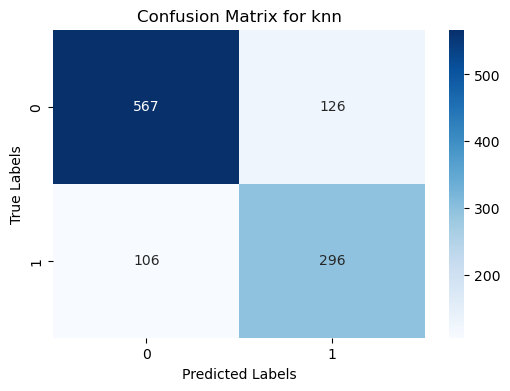

In [38]:
confusion = knn_model.results["Confusion Matrix"]
labels = sorted(np.unique(y_test))  # Ensure proper labels
plot_confusion_matrix(confusion, labels, title=f"Confusion Matrix for {knn_model.name}")

### K-nn with PCA

In [76]:
# Initialize KNN Model with PCA
knn_pca_model = ModelPipeline(
    model=KNeighborsClassifier(), 
    name="knn_pca",               
    standardize=True,              
    with_pca=True,                 
    n_pca_components=10            
)

# Create the pipeline
knn_pca_model.create_pipeline()

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('knn_pca', KNeighborsClassifier())])

In [77]:
knn_pca_model.evaluate(X_train, X_test, y_train, y_test)

Evaluation Results: {'Model': 'knn_pca', 'Accuracy': 0.9315068493150684, 'Balanced Accuracy': 0.9145506235058474, 'F1 Score': 0.9011857707509882, 'AUC': 0.971315859375561, 'Confusion Matrix': [[678, 15], [60, 342]]}


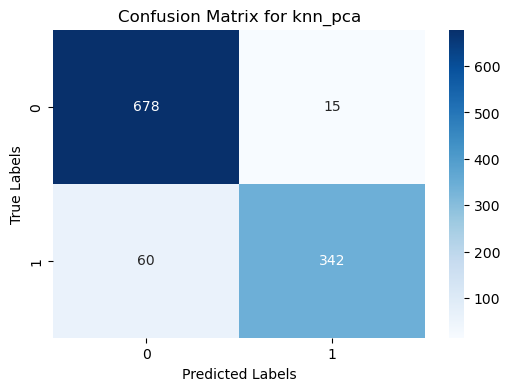

In [78]:
knn_pca_confusion = knn_pca_model.results["Confusion Matrix"]
knn_pca_labels = sorted(np.unique(y_test))
plot_confusion_matrix(knn_pca_confusion, knn_pca_labels, title=f"Confusion Matrix for {knn_pca_model.name}")

### Tuning GDBT without PCA

In [ ]:
# Initialize GBDT Model without PCA
gbdt_model = ModelPipeline(
    model=GradientBoostingClassifier(),
    name="gbdt",
    standardize=False,
    with_pca=False
)

# Create the pipeline
gbdt_model.create_pipeline()

# Apply fixed parameters
gbdt_fixed_params = {
    "gbdt__loss": "log_loss", # binary classification task by optimizing probabilistic predictions
    "gbdt__n_iter_no_change": 15  # Early stopping to save time and prevent overfitting
}

# Apply fixed parameters
gbdt_model.set_params(gbdt_fixed_params)

gbdt_grid = [
    {
        "gbdt__n_estimators": [100, 200, 300, 400, 500],  # ore trees capture finer patterns but increae the risk of overfitting plus more computation
        "gbdt__max_depth": [1, 3, 5, 7, 9],               # Smaller values (1) create shallow trees emphasizing simplicity while larger values (9) increase capacity for complex patterns
        "gbdt__learning_rate": [0.1, 0.05, 0.2, 0.3],     # Step size at each boosting operation
        "gbdt__max_features": ["sqrt", 100, 130]          # Features to consider when looking for the best split
    }
]

In [ ]:
gbdt_model.tune(X_train, y_train, gbdt_grid)

In [44]:
gbdt_model.evaluate(X_train, X_test, y_train, y_test)

Valid Parameters for Pipeline: {'gbdt__learning_rate': 0.1, 'gbdt__max_depth': 3, 'gbdt__max_features': 'sqrt', 'gbdt__n_estimators': 400}
Evaluation Results: {'Model': 'gbdt', 'Accuracy': 0.9634703196347032, 'Balanced Accuracy': 0.9549492795761452, 'F1 Score': 0.948849104859335, 'AUC': 0.9942997853445615, 'Confusion Matrix': [[684, 9], [31, 371]]}


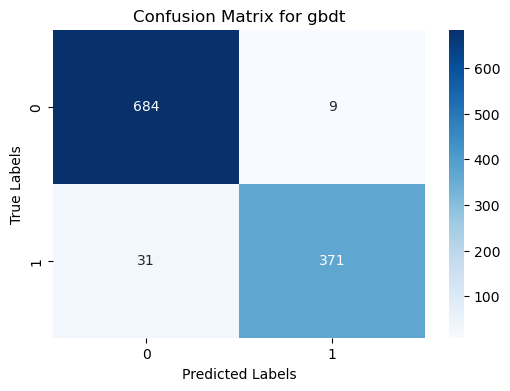

In [45]:
gbdt_confusion = gbdt_model.results["Confusion Matrix"]
gbdt_labels = sorted(np.unique(y_test))
plot_confusion_matrix(gbdt_confusion, gbdt_labels, title=f"Confusion Matrix for {gbdt_model.name}")

### Tuning GDBT with PCA

In [79]:
# Initialize GBDT Model with PCA
gbdt_pca_model = ModelPipeline(
    model=GradientBoostingClassifier(random_state=42),
    name="gbdt_pca",                                   
    standardize=False,                                  
    with_pca=True,                                      
    n_pca_components=10                                 
)

# Create the pipeline
gbdt_pca_model.create_pipeline()

Pipeline(steps=[('pca', PCA(n_components=10)),
                ('gbdt_pca', GradientBoostingClassifier(random_state=42))])

In [80]:
gbdt_pca_model.evaluate(X_train, X_test, y_train, y_test)

Evaluation Results: {'Model': 'gbdt_pca', 'Accuracy': 0.9406392694063926, 'Balanced Accuracy': 0.9285552755702009, 'F1 Score': 0.9161290322580645, 'AUC': 0.9846618279454101, 'Confusion Matrix': [[675, 18], [47, 355]]}


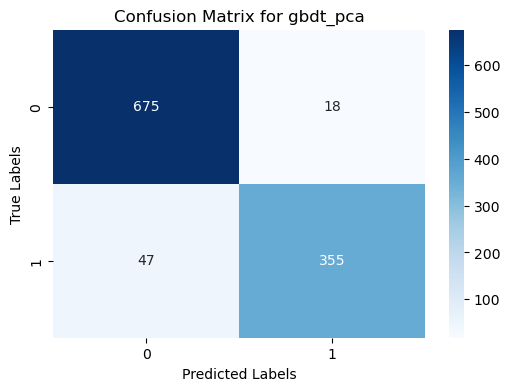

In [81]:
gbdt_pca_confusion = gbdt_pca_model.results["Confusion Matrix"]
gbdt_pca_labels = sorted(np.unique(y_test))
plot_confusion_matrix(gbdt_pca_confusion, gbdt_pca_labels, title=f"Confusion Matrix for {gbdt_pca_model.name}")

### Tuning Random Forest without PCA

In [ ]:
# Initialize RF Model without PCA
rf_model = ModelPipeline(
    model=RandomForestClassifier(),
    name="rf",
    standardize=False, # Not required for RF
    with_pca=False
)

# Create the pipeline
rf_model.create_pipeline()

rf_fixed_params = {
    "rf__bootstrap": True 
}

rf_model.set_params(rf_fixed_params)

# Define grid search parameters
rf_grid = [
    {
        "rf__n_estimators": [100, 200, 300, 400],    # higher number increases predictive stability and accuracy but comes with a computational cost
        "rf__criterion": ["gini", "entropy"],       # Splitting criterion
        "rf__max_features": ["sqrt", "log2"]        # Determines how many features are considered at each split:
    }
]


In [ ]:
rf_model.tune(X_train, y_train, rf_grid)

In [51]:
rf_model.evaluate(X_train, X_test, y_train, y_test)

Valid Parameters for Pipeline: {'rf__criterion': 'gini', 'rf__max_features': 'sqrt', 'rf__n_estimators': 300}
Evaluation Results: {'Model': 'rf', 'Accuracy': 0.94337899543379, 'Balanced Accuracy': 0.9244524132583833, 'F1 Score': 0.9171122994652406, 'AUC': 0.9925552612119776, 'Confusion Matrix': [[690, 3], [59, 343]]}


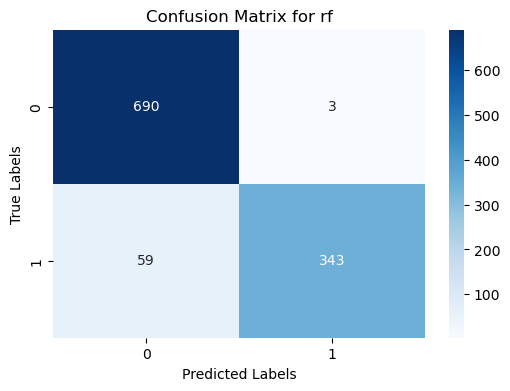

In [52]:
rf_confusion = rf_model.results["Confusion Matrix"]
rf_labels = sorted(np.unique(y_test))
plot_confusion_matrix(rf_confusion, rf_labels, title=f"Confusion Matrix for {rf_model.name}")

### Tuning Random Forest with PCA

In [82]:
# Initialize RF Model with PCA
rf_pca_model = ModelPipeline(
    model=RandomForestClassifier(random_state=42),  # Include random_state for reproducibility
    name="rf_pca",                                  # Model name with PCA
    standardize=False,                              # Standardization not required for RF
    with_pca=True,                                  # Include PCA
    n_pca_components=10                             # Set PCA to 10 components
)

# Create the pipeline
rf_pca_model.create_pipeline()

Pipeline(steps=[('pca', PCA(n_components=10)),
                ('rf_pca', RandomForestClassifier(random_state=42))])

In [83]:
# Evaluate the Random Forest model with PCA
rf_pca_model.evaluate(X_train, X_test, y_train, y_test)

Evaluation Results: {'Model': 'rf_pca', 'Accuracy': 0.9415525114155251, 'Balanced Accuracy': 0.9297990566647283, 'F1 Score': 0.9175257731958762, 'AUC': 0.9815748099330189, 'Confusion Matrix': [[675, 18], [46, 356]]}


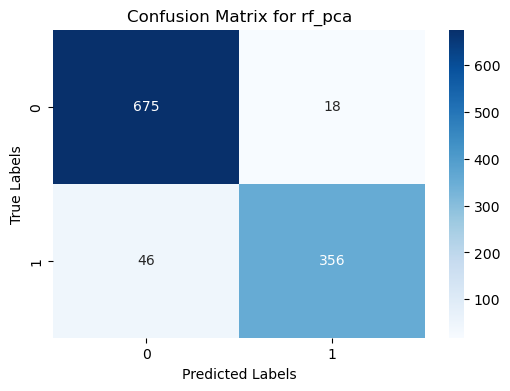

In [84]:
# Retrieve the confusion matrix and plot it
rf_pca_confusion = rf_pca_model.results["Confusion Matrix"]
rf_pca_labels = sorted(np.unique(y_test))
plot_confusion_matrix(rf_pca_confusion, rf_pca_labels, title=f"Confusion Matrix for {rf_pca_model.name}")

### Tuning SVM without PCA

In [ ]:
# Initialize SVM Model without PCA
svm_model = ModelPipeline(
    model=SVC(),
    name="svm",
    standardize=True, # Sesitive to feature scaling
    with_pca=False
)

# Create the pipeline
svm_model.create_pipeline()

# Apply fixed parameters
svm_fixed_params = {
    "svm__degree": 3  # Degree of the polynomial kernel function
}

# Apply fixed parameters
svm_model.set_params(svm_fixed_params)

# Define grid search parameters
svm_grid = [
    {
        "svm__C": [0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801, 0.901, 1.001, 5, 10], # Regularization parameter minimal / balanced / heavy regularisation
        "svm__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "svm__gamma": ["scale", "auto"], # Influence of individual trainng points
        "svm__class_weight": [None, "balanced"] # Assume balced or Adjusts weights inversely proportional to class frequencies for minority classes treatment
    }
]


In [ ]:
svm_model.tune(X_train, y_train, svm_grid)

In [58]:
svm_model.evaluate(X_train, X_test, y_train, y_test)


Valid Parameters for Pipeline: {'svm__C': 0.601, 'svm__class_weight': 'balanced', 'svm__gamma': 'scale', 'svm__kernel': 'sigmoid'}
Evaluation Results: {'Model': 'svm', 'Accuracy': 0.9561643835616438, 'Balanced Accuracy': 0.952833236415326, 'F1 Score': 0.9402985074626866, 'AUC': None, 'Confusion Matrix': [[669, 24], [24, 378]]}


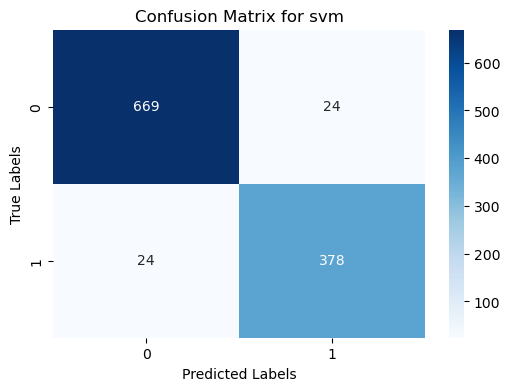

In [59]:
svm_confusion = svm_model.results["Confusion Matrix"]
svm_labels = sorted(np.unique(y_test))
plot_confusion_matrix(svm_confusion, svm_labels, title=f"Confusion Matrix for {svm_model.name}")

### Tuning SVM with PCA

In [85]:
svm_pca_model = ModelPipeline(
    model=SVC(random_state=42), 
    name="svm_pca",             
    standardize=True,           
    with_pca=True,              
    n_pca_components=10         
)

svm_pca_model.create_pipeline()

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('svm_pca', SVC(random_state=42))])

In [86]:
svm_pca_model.evaluate(X_train, X_test, y_train, y_test)

Evaluation Results: {'Model': 'svm_pca', 'Accuracy': 0.960730593607306, 'Balanced Accuracy': 0.9527847774116431, 'F1 Score': 0.9452229299363057, 'AUC': None, 'Confusion Matrix': [[681, 12], [31, 371]]}


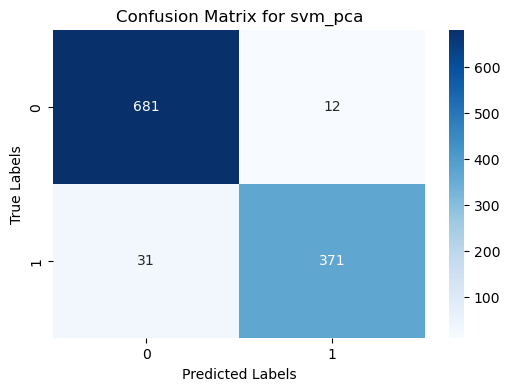

In [87]:
svm_pca_confusion = svm_pca_model.results["Confusion Matrix"]
svm_pca_labels = sorted(np.unique(y_test))
plot_confusion_matrix(svm_pca_confusion, svm_pca_labels, title=f"Confusion Matrix for {svm_pca_model.name}")

### Final Table for 1.2

In [107]:
models = [
    lda_model, lda_pca_model,          
    logit_model, logit_pca_model,       
    qda_model, qda_pca_model,          
    knn_model, knn_pca_model,           
    gbdt_model, gbdt_pca_model,         
    rf_model, rf_pca_model,            
    svm_model, svm_pca_model         
]

results_df = aggregate_results(models)

print("Aggregated Results:")
results_df


Aggregated results saved to Model_Comparison_Results.csv
Aggregated Results:


,Model,Accuracy,Balanced Accuracy,F1 Score,AUC,Confusion Matrix
0,lda,0.965297,0.955870,0.951157,0.993234,"[[687, 6], [32, 370]]"
1,lda_pca,0.943379,0.924452,0.917112,0.989838,"[[690, 3], [59, 343]]"
2,logit,0.957991,0.953754,0.942500,0.993485,"[[672, 21], [25, 377]]"
3,logit_pca,0.960731,0.954874,0.945776,0.991593,"[[677, 16], [27, 375]]"
4,qda,0.367123,0.500000,0.537074,0.500000,"[[0, 693], [0, 402]]"
5,qda_pca,0.953425,0.945446,0.935197,0.989687,"[[676, 17], [34, 368]]"
6,knn,0.788128,0.777250,0.718447,0.873755,"[[567, 126], [106, 296]]"
7,knn_pca,0.931507,0.914551,0.901186,0.971316,"[[678, 15], [60, 342]]"
8,gbdt,0.963470,0.954949,0.948849,0.994300,"[[684, 9], [31, 371]]"
9,gbdt_pca,0.940639,0.928555,0.916129,0.984662,"[[675, 18], [47, 355]]"


# Task 1.3 Extra Evaluation

### Adaboost with PCA

In [ ]:
ada_boost_pca_model = ModelPipeline(
    model=AdaBoostClassifier(random_state=42),
    name="ada_boost_pca",
    standardize=True,
    with_pca=True 
)

ada_boost_pca_model.create_pipeline()

ada_boost_fixed_params = {
    "ada_boost_pca__algorithm": "SAMME" # supports multi-class classification and maintains simplicity in boosting
}
ada_boost_pca_model.set_params(ada_boost_fixed_params)

ada_boost_pca_grid = [
    {
        "ada_boost_pca__estimator": [DecisionTreeClassifier(max_depth=2), LogisticRegression()], # Base learners (Shallow decision trees / linear model to evaluate its performance when combined with boosting)
        "ada_boost_pca__n_estimators": [50, 100, 200, 300, 400], # Number of boosting rounds (reduce bias and variance)
        "ada_boost_pca__learning_rate": [0.05, 0.1, 0.2, 0.5, 0.6, 1, 1.5], # Cotribution of each learner (braod range to explore conservative and aggressive updates)
        "pca__n_components": [8, 10, 12, 15, 20]  # Explore dimensionality of transformed data
    }
]


In [ ]:
ada_boost_pca_model.tune(X_train, y_train, ada_boost_pca_grid)

In [115]:
ada_boost_pca_model.evaluate(X_train, X_test, y_train, y_test)

Valid Parameters for Pipeline: {'ada_boost_pca__estimator': LogisticRegression(), 'ada_boost_pca__learning_rate': 0.2, 'ada_boost_pca__n_estimators': 300, 'pca__n_components': 20}
Evaluation Results: {'Model': 'ada_boost_pca', 'Accuracy': 0.9634703196347032, 'Balanced Accuracy': 0.9606943636794383, 'F1 Score': 0.9502487562189055, 'AUC': 0.9754707702468898, 'Confusion Matrix': [[673, 20], [20, 382]]}


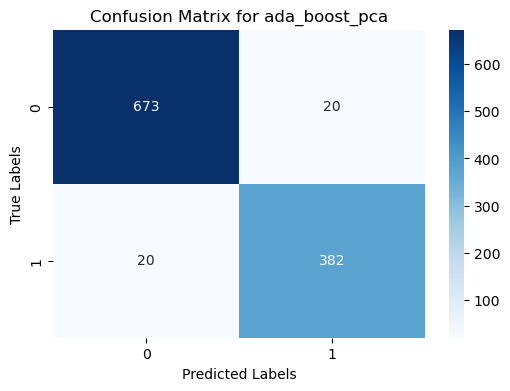

In [116]:
ada_boost_pca_confusion = ada_boost_pca_model.results["Confusion Matrix"]
ada_boost_pca_labels = sorted(np.unique(y_test))
plot_confusion_matrix(ada_boost_pca_confusion, ada_boost_pca_labels, title=f"Confusion Matrix for {ada_boost_pca_model.name}")

### Threshhold optimization technique

In [108]:
def optimize_threshold(model, X_val, y_val, metric=f1_score, thresholds=np.linspace(0, 1, 101)):
    """
    Optimizes the decision threshold for a trained model based on a specified metric.
    """
    probs = model.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class
    threshold_scores = {}

    for threshold in thresholds:
        y_pred = (probs >= threshold).astype(int)
        score = metric(y_val, y_pred)
        threshold_scores[threshold] = score

    best_threshold = max(threshold_scores, key=threshold_scores.get)
    best_score = threshold_scores[best_threshold]
    return best_threshold, best_score, threshold_scores

In [109]:
def plot_threshold_vs_metric(threshold_scores, best_threshold, best_score, model_name, metric_name="F1 Score"):
    """
    Plots the relationship between thresholds and the evaluation metric.
    """
    thresholds = list(threshold_scores.keys())
    scores = list(threshold_scores.values())

    plt.figure(figsize=(7, 5))
    plt.plot(thresholds, scores, label=f"{metric_name} vs. Threshold", marker="o", color="#4e79a7")
    plt.axvline(best_threshold, color="orange", linestyle="--", label=f"Optimal Threshold = {best_threshold:.2f}")
    plt.axhline(best_score, color="green", linestyle="--", label=f"Best {metric_name} = {best_score:.3f}")
    plt.axvline(0.5, color="red", linestyle=":", label="Default Threshold = 0.5")
    plt.title(f"{metric_name} vs. Decision Threshold for {model_name}", fontsize=14)
    plt.xlabel("Decision Threshold", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.legend(fontsize=10)
    plt.grid()
    plt.show()

In [110]:
def apply_threshold_optimization(model_pipeline, X_test, y_test, save_plots=True, plot_dir="Threshold_Plots"):
    """
    Applies threshold optimization to the provided model and generates a plot.
    """
    os.makedirs(plot_dir, exist_ok=True)  # Ensure the directory exists

    model_name = model_pipeline.name
    best_model = model_pipeline.pipeline

    if not hasattr(best_model, "predict_proba"):
        print(f"Skipping {model_name}: does not support probability prediction.")
        return None

    original_f1_score = model_pipeline.results["F1 Score"]

    # Optimize Threshold
    best_threshold, best_f1, threshold_scores = optimize_threshold(
        model=best_model,
        X_val=X_test,
        y_val=y_test,
        metric=f1_score
    )

    # Apply the new threshold to test data
    y_test_pred = (best_model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)
    new_f1_score = f1_score(y_test, y_test_pred)

    # Generate the plot
    if save_plots:
        plot_threshold_vs_metric(
            threshold_scores,
            best_threshold,
            best_f1,
            model_name=model_name,
            metric_name="F1 Score"
        )
        plt.savefig(os.path.join(plot_dir, f"{model_name}_threshold_plot.png"))
        plt.close()

    return {
        "Model": model_name,
        "Original F1 Score": original_f1_score,
        "Optimal Threshold": best_threshold,
        "New F1 Score": new_f1_score
    }

In [111]:
def analyze_threshold_optimization(models, X_test, y_test, save_plots=True, plot_dir="Threshold_Plots"):
    """
    Applies threshold optimization across all applicable models and aggregates results.
    """
    results = []

    for model in models:
        result = apply_threshold_optimization(model, X_test, y_test, save_plots=save_plots, plot_dir=plot_dir)
        if result:  # Only add if the model supports threshold optimization
            results.append(result)

    results_df = pd.DataFrame(results)
    results_df.to_csv("Threshold_Optimization_Results.csv", index=False)
    print("Threshold optimization results saved to Threshold_Optimization_Results.csv")
    return results_df

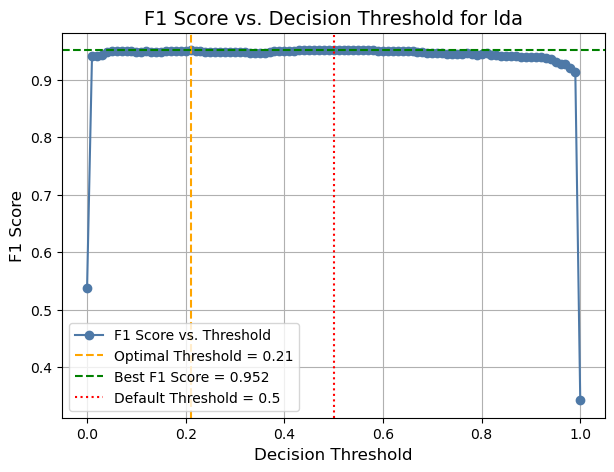

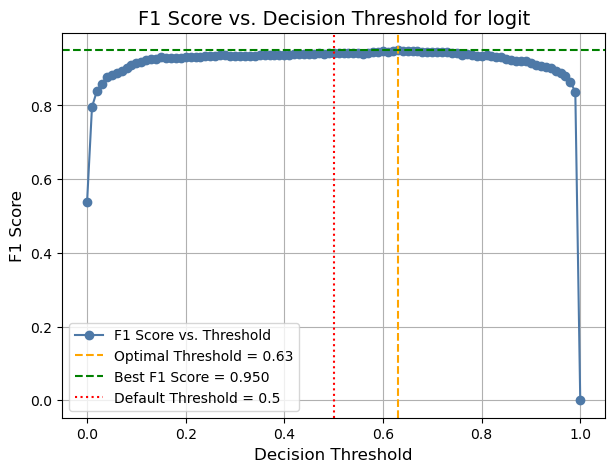

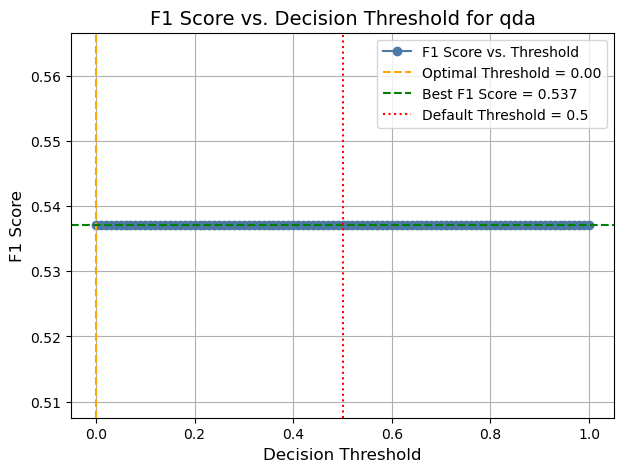

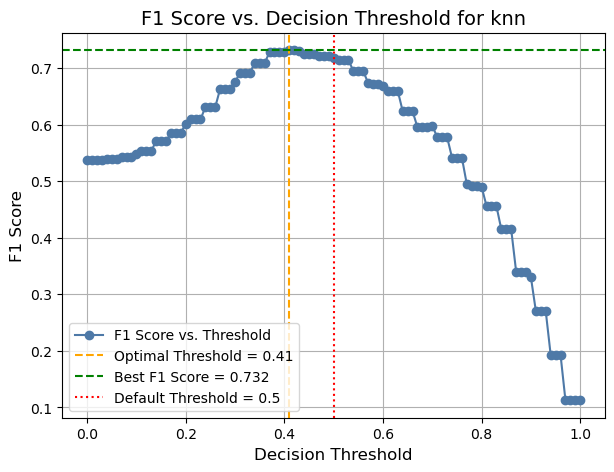

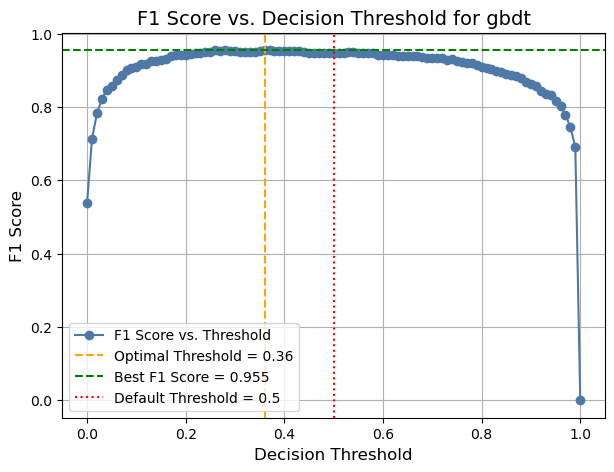

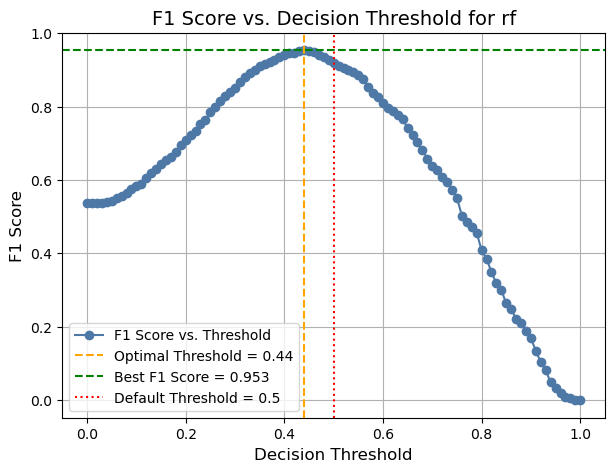

Skipping svm: does not support probability prediction.
Threshold optimization results saved to Threshold_Optimization_Results.csv


,Model,Original F1 Score,Optimal Threshold,New F1 Score
0,lda,0.951157,0.21,0.951531
1,logit,0.942500,0.63,0.949936
2,qda,0.537074,0.00,0.537074
3,knn,0.718447,0.41,0.731551
4,gbdt,0.948849,0.36,0.955112
5,rf,0.917112,0.44,0.953459


In [112]:
# Example tuned models
models = [
    lda_model, logit_model, qda_model, knn_model, gbdt_model, rf_model, svm_model
]

# Apply threshold optimization and generate plots
threshold_optimization_results = analyze_threshold_optimization(
    models=models,
    X_test=X_test,
    y_test=y_test,
    save_plots=True,
    plot_dir="Threshold_Plots"
)

# Display the results
threshold_optimization_results

### SVM with PCA variation

In [133]:
svm_pca_model = ModelPipeline(
    model=SVC(),               
    name="svm_pca",
    standardize=True,            
    with_pca=True                
)

svm_pca_model.create_pipeline()

pca_components = list(range(5, 105, 5)) + list(range(100, 1100, 100))

svm_pca_grid = [
    {
        "pca__n_components": pca_components
    }
]

In [ ]:
svm_pca_model.tune(X_train, y_train, svm_pca_grid)

In [135]:
svm_pca_model.evaluate(X_train, X_test, y_train, y_test)


Valid Parameters for Pipeline: {'pca__n_components': 30}
Evaluation Results: {'Model': 'svm_pca', 'Accuracy': 0.9689497716894977, 'Balanced Accuracy': 0.9629342465163361, 'F1 Score': 0.9569620253164557, 'AUC': None, 'Confusion Matrix': [[683, 10], [24, 378]]}


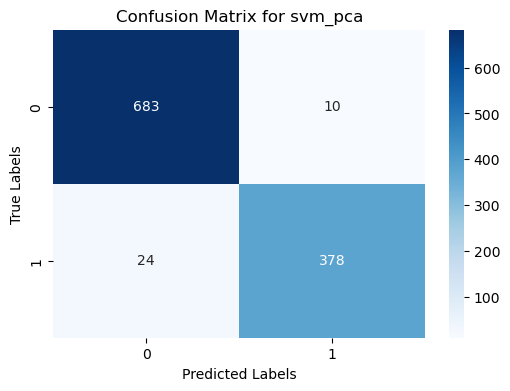

In [136]:
svm_pca_confusion = svm_pca_model.results["Confusion Matrix"]
svm_pca_labels = sorted(np.unique(y_test))
plot_confusion_matrix(svm_pca_confusion, svm_pca_labels, title=f"Confusion Matrix for {svm_pca_model.name}")

/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model svm_pca_finetune_extra tuned in 0.25 minutes
Valid Parameters for Pipeline: {'pca__n_components': 22}
Evaluation Results: {'Model': 'svm_pca_finetune_extra', 'Accuracy': 0.9689497716894977, 'Balanced Accuracy': 0.9639788072623894, 'F1 Score': 0.9571788413098237, 'AUC': None, 'Confusion Matrix': [[681, 12], [22, 380]]}


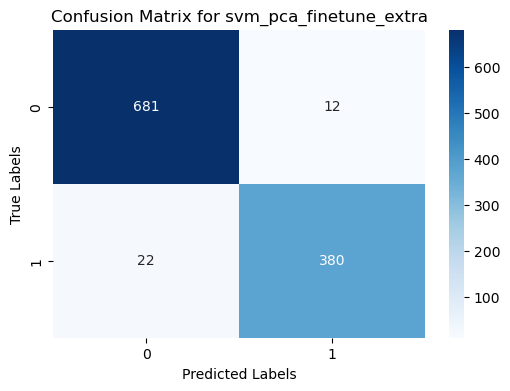

In [ ]:
svm_pca_model_extra = ModelPipeline(
    model=SVC(),               
    name="svm_pca_finetune_extra",   # Updated name to reflect fine-tuning
    standardize=True,            
    with_pca=True                
)

svm_pca_model_extra.create_pipeline()

pca_finetune_components_extra = list(range(20, 41, 1))  # Narrow range for fine-tuning (20 to 40 in steps of 1)

svm_pca_finetune_grid_extra = [
    {
        "pca__n_components": pca_finetune_components_extra
    }
]

svm_pca_model_extra.tune(X_train, y_train, svm_pca_finetune_grid_extra)

svm_pca_model_extra.evaluate(X_train, X_test, y_train, y_test)

svm_pca_confusion_extra = svm_pca_model_extra.results["Confusion Matrix"]
svm_pca_labels_extra = sorted(np.unique(y_test))
plot_confusion_matrix(svm_pca_confusion_extra, svm_pca_labels_extra, title=f"Confusion Matrix for {svm_pca_model_extra.name}")

# 1.4 Picking the best model and using mypredict()

### All necessary cells to run to produce the final output imcluding neccessary packages

In [7]:
import pandas as pd
import numpy as np
import joblib 

from sklearn.svm import SVC 
from sklearn.preprocessing import StandardScaler  
from sklearn.decomposition import PCA  
from sklearn.pipeline import Pipeline 
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score

import gzip

In [8]:
class ModelPipeline:
    def __init__(self, model, name, standardize=False, with_pca=False, n_pca_components=10, random_state=42):
        self.model = model
        self.name = name
        self.standardize = standardize
        self.with_pca = with_pca
        self.n_pca_components = n_pca_components
        self.random_state = random_state

        self.pipeline = None
        self.best_params = {}
        self.results = {}  # Store evaluation results for each model

        # Ensure model uses random_state if supported (fixing randomness for reproducibility)
        if "random_state" in self.model.get_params():
            self.model.set_params(random_state=self.random_state)

    def create_pipeline(self):
        steps = []
        if self.standardize:
            steps.append(('scaler', StandardScaler()))
        if self.with_pca:
            steps.append(('pca', PCA(n_components=self.n_pca_components)))
        steps.append((self.name, self.model))
        self.pipeline = Pipeline(steps)
        # print(f"Pipeline Created: {self.pipeline}") debugged!
        return self.pipeline

    def set_params(self, params):
        if not self.pipeline:
            raise ValueError("Pipeline not created. Call create_pipeline() first.")
        self.pipeline.set_params(**params)

    def tune(self, X_train, y_train, param_grid, scoring="f1", cv_folds=5, n_jobs=-1):
        # Esnsure pipeline is created
        if not self.pipeline:
            self.create_pipeline() 

        # Setup GridSearchCV with the pipeline
        grid_search = GridSearchCV(
            self.pipeline,
            param_grid=param_grid,
            scoring=scoring,
            cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state),
            n_jobs=n_jobs,
            verbose=0
        )
        start_time = time.time() # Track tuning time
        grid_search.fit(X_train, y_train) # Fit the grid search
        elapsed_time = (time.time() - start_time) / 60 # Time in minutes (Some model tuning takes over an hour)

        # Store the best parameters and save results
        self.best_params = grid_search.best_params_
        self.best_params["MODEL_NAME"] = self.name
        self.best_params["TIME_ELAPSED_MIN"] = elapsed_time

        # Handle non-serializable objects
        serializable_params = {
            k: (str(v) if not isinstance(v, (int, float, str, list, dict)) else v)
            for k, v in self.best_params.items()
        }

        # Save all results and best parameters
        full_results = pd.DataFrame(grid_search.cv_results_)
        full_results.to_csv(f"Tuning_params/{self.name}_all_results.csv", index=False)
        with open(f"Tuning_params/{self.name}_best_params.json", "w") as f:
            json.dump(serializable_params, f, indent=4)
        print(f"Model {self.name} tuned in {elapsed_time:.2f} minutes") #log running time

    def evaluate(self, X_train, X_test, y_train, y_test):
        if not self.pipeline:
            self.create_pipeline()

        if self.best_params:
            # Filter only valid pipeline parameters (Important for Adaboost)
            valid_params = {
                key: value for key, value in self.best_params.items()
                if key in self.pipeline.get_params()
            }
            print(f"Valid Parameters for Pipeline: {valid_params}")
            self.pipeline.set_params(**valid_params) # Set valid params

        # Train the pipeline on training data
        self.pipeline.fit(X_train, y_train)
        # Predict on test data
        y_pred = self.pipeline.predict(X_test)

        # Compute evaluation metrics
        metrics = {
            "Model": self.name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
        }

        # Calculate AUC if available (not available forr SVM)
        if hasattr(self.pipeline, "predict_proba"):
            metrics["AUC"] = roc_auc_score(y_test, self.pipeline.predict_proba(X_test)[:, 1])
        else:
            metrics["AUC"] = None

        # Add confusion matrix (fir plot)
        metrics["Confusion Matrix"] = confusion_matrix(y_test, y_pred).tolist()
        print(f"Evaluation Results: {metrics}")

        # # Save evaluation metrics
        self.results = metrics
        pd.DataFrame([metrics]).to_csv(f"Tuning_params/{self.name}_evaluation_summary.csv", index=False)



### Selecting SVM with 22 pca components and retraining it on the entire dataset

In [9]:
data = pd.read_csv("data.csv.gz", compression="gzip")

X_full = data.drop(columns=["label"])
y_full = data["label"]

best_model_pipeline = ModelPipeline(
    model=SVC(probability=True, random_state=42), 
    name="svm_final_model",                       
    standardize=True,                             
    with_pca=True,                               
    n_pca_components=22                           
)

best_model_pipeline.create_pipeline()
best_model_pipeline.pipeline.fit(X_full, y_full)

joblib.dump(best_model_pipeline.pipeline, 'final_svm_model.pkl')
print("Final model saved as 'final_svm_model.pkl'.")

Final model saved as 'final_svm_model.pkl'.


### Create mypredict() function

In [11]:
def mypredict():
    """
    Predicts the class labels for a test dataset using the trained and saved SVM model.
    This function assumes that the test dataset is in a compressed CSV file named `test.csv.gz` 
    in the same directory and has the same format as the training dataset.
    """
    
    model_file = "final_svm_model.pkl"
    test_file = "test.csv.gz"
    output_file = "predictions.txt"

    # Step 1: Load the trained model after running the previous cells
    try:
        model = joblib.load(model_file)
        print(f"Model successfully loaded from {model_file}")
    except FileNotFoundError:
        raise FileNotFoundError(f"Trained model file '{model_file}' not found. Ensure it exists in the working directory after running the previous related cells.")
    except Exception as e:
        raise RuntimeError(f"An error occurred while loading the model: {e}")

    # Step 2: Load the test dataset
    try:
        test_data = pd.read_csv(test_file, compression="gzip")
        print(f"Test data successfully loaded from {test_file}")
    except FileNotFoundError:
        raise FileNotFoundError(f"Test data file '{test_file}' not found. Ensure it exists in the current working directory.")
    except Exception as e:
        raise RuntimeError(f"An error occurred while loading the test file: {e}")

    # Step 3: Prepare test data (SAme format as original data)
    if "label" in test_data.columns:
        test_data = test_data.drop(columns=["label"])  # Drop label column if present

    # Step 4: Generate predictions as specified
    try:
        predictions = model.predict(test_data)
        print("Predictions generated successfully.")
    except Exception as e:
        raise RuntimeError(f"An error occurred during prediction: {e}")

    # Step 5: Save predictions to a txt file
    try:
        with open(output_file, "w") as f:
            for pred in predictions:
                f.write(f"{pred}\n")
        print(f"Predictions saved to {output_file}")
    except Exception as e:
        raise RuntimeError(f"An error occurred while saving predictions: {e}")

In [12]:
mypredict()

Model successfully loaded from final_svm_model.pkl
Test data successfully loaded from test.csv.gz
Predictions generated successfully.
Predictions saved to predictions.txt
